## Preliminaries

In [252]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [238]:
%matplotlib inline
seed = 1
rng_key = random.PRNGKey(seed)

## Generate dummy data

In [239]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
def gen_items(num_items, rng_key):
    keys = random.split(rng_key,2)
    item_quality = dist.Uniform(1, 10).sample(keys[0], (num_items,))
    list_price = jnp.maximum(dist.Normal(item_quality, 1.0).sample(keys[1]),1.0) * 20
    #plt.scatter(item_quality, list_price)
    return item_quality, list_price

_ = gen_items(100, rng_key)

In [240]:
def lognormal_params(mu, sigma):
    loc = np.log(mu**2/np.sqrt(mu**2 + sigma**2))
    scale = np.sqrt(np.log(1 + sigma**2/mu**2))
    return loc, scale


def gen_cust(num_cust, rng_key):
    keys = random.split(rng_key,3)

    beta_quality_loc = dist.Uniform(5,10).sample(keys[0])
    beta_quality_scale = dist.Uniform(1,2).sample(keys[1])
    loc, scale = lognormal_params(beta_quality_loc, beta_quality_scale)
    beta_quality = dist.LogNormal(loc, scale).expand((num_cust,)).sample(keys[2])
    mean_beta_quality = jnp.mean(beta_quality)
    std_beta_quality = jnp.std(beta_quality)
    print('mean_beta_quality: ' + str(mean_beta_quality), 'std_beta_quality: ' + str(std_beta_quality))

    return beta_quality

_ = gen_cust(10, rng_key)

mean_beta_quality: 7.6662745 std_beta_quality: 0.94968593


In [241]:
def gen_sales(num_sales, rng_key):
    keys = random.split(rng_key,2)
    sales_wtp_bias = dist.Uniform(-0.2,0.1).expand((num_sales,)).sample(keys[0])
    sales_wtp_uncertainty = dist.Uniform(0.1,0.5).expand([num_sales,]).sample(keys[1])
    print('mean_wtp_bias: ' + str(jnp.mean(sales_wtp_bias)), 'std_wtp_bias: ' + str(jnp.std(sales_wtp_bias)))
    print('mean_wtp_uncertainty: ' + str(jnp.mean(sales_wtp_uncertainty)), 'std_wtp_uncertainty: ' + str(jnp.std(sales_wtp_uncertainty)))
    return sales_wtp_bias, sales_wtp_uncertainty

_ = gen_sales(20, rng_key)

mean_wtp_bias: -0.060042 std_wtp_bias: 0.083096355
mean_wtp_uncertainty: 0.34853464 std_wtp_uncertainty: 0.098519154


In [242]:
def gen_quotes(max_items_per_cust, num_cust, num_items, rng_key):
    keys = random.split(rng_key,3)
    concentration = jnp.full(max_items_per_cust, 5.0)
    item_probs = dist.Dirichlet(concentration).sample(keys[0])
    num_item_by_cust = dist.Categorical(item_probs).sample(keys[1], (num_cust,))
    #plt.hist(num_item_by_cust, bins=max_items_per_cust)

    customer_id_list = []
    customer_items_list = []
    key = keys[2]
    for customer, num_items_for_cust in enumerate(num_item_by_cust):
        customer_id_inc = [customer] * num_items_for_cust
        customer_items_inc = random.choice(key, num_items, (num_items_for_cust,), replace=True)
        key = random.split(key,1)[0]
        #customer_items_inc = torch.randperm(num_items)[:num_items_for_cust].tolist()
        customer_id_list.extend(customer_id_inc)
        customer_items_list.extend(customer_items_inc)
        
    customer_id = jnp.array(customer_id_list, dtype=jnp.int32)
    customer_items = jnp.array(customer_items_list, dtype=jnp.int32)
    #print(customer_id.shape, customer_items.shape)

    num_quotes = customer_items.shape[0]
    return customer_id, customer_items, num_quotes

_ = gen_quotes(5, 10, 20, rng_key)

In [243]:
def gen_negotiations(X, rng_key):

    keys = random.split(rng_key,1)

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer_id = jnp.array(X['customer'])
    x_item = jnp.array(X['item'])
    x_beta_quality = jnp.array(X['beta_quality'])
    x_sales_wtp_bias = jnp.array(X['sales_wtp_bias'])
    x_sales_wtp_uncertainty = jnp.array(X['sales_wtp_uncertainty'])

    num_quotes = len(X)

    y = {}
    key = keys[0]
    for q in range(num_quotes):
        c = x_customer_id[q]
        s = x_salesperson[q]
        i = x_item[q]
        wtp = jnp.minimum(x_item_quality[q] * x_beta_quality[q], x_list_price[q])
        est_wtp = jnp.minimum(dist.Normal(wtp*(1.0+x_sales_wtp_bias[q]), wtp*x_sales_wtp_uncertainty[q]).sample(key), x_list_price[q])
        key = random.split(key,1)[0]
        #print(wtp, x_list_price[q], est_wtp, wtp.dtype, est_wtp.dtype)
        if wtp >= x_list_price[q]:
            result = 1
            price = x_list_price[q]
        if wtp < est_wtp:
            result = 0
            price = np.nan
        else:
            result = 1
            price = ( est_wtp + wtp ) /2
        y[q] = {'result':result, 'price':price, 'wtp':wtp, 'est_wtp':est_wtp}

    return y


In [244]:
def sequential_idx(X):
    # map customer, item and salesperson ids to sequential versions of same for convenience later
    customer_map = {}
    for i, c in enumerate(X['customer'].unique()):
        customer_map[c] = i
    item_map = {}
    for i, item in enumerate(X['item'].unique()):
        item_map[item] = i
    salesperson_map = {}
    for i, s in enumerate(X['salesperson'].unique()):
        salesperson_map[s] = i

    X['customer'] = X['customer'].map(customer_map)
    X['item'] = X['item'].map(item_map)
    X['salesperson'] = X['salesperson'].map(salesperson_map)

    return X

In [255]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay

def gen_negs(rng_key):

    keys = random.split(rng_key,6)

    num_items = 10
    item_quality, list_price = gen_items(num_items, keys[0])
    
    num_cust = 20
    beta_quality = gen_cust(num_cust, keys[1])

    # Generate salespeople
    # Each salesperson has an ability to estimate the customers wtp subject to some bias and uncertainty
    num_sales = 10
    sales_wtp_bias, sales_wtp_uncertainty = gen_sales(num_sales, keys[2])

    # Generate quotes
    ## Each customer generates a number of quotes for items
    max_items_per_customer = 50
    customer_id, customer_items, num_quotes = gen_quotes(max_items_per_customer, num_cust, num_items, keys[3])

    ## Salespeople ramdomly assigned to quotes
    salesperson = random.choice(keys[4], num_sales, (num_quotes,), replace=True)

    # Negotiate quotes, get result and agreed price
    X = pd.DataFrame({'customer':customer_id, 'beta_quality':beta_quality[customer_id], 'item':customer_items, 'item_quality':item_quality[customer_items]
        , 'list_price':list_price[customer_items], 'salesperson':salesperson, 'sales_wtp_bias':sales_wtp_bias[salesperson], 'sales_wtp_uncertainty':sales_wtp_uncertainty[salesperson]})

    # map customer, item and salesperson ids to sequential versions of same for convenience later
    X = sequential_idx(X)

    y_dict = gen_negotiations(X, keys[5])
    y = pd.DataFrame.from_dict(y_dict, orient='index', dtype = 'float', columns=['result', 'price', 'wtp', 'est_wtp'])
    
    return pd.concat([X,y], axis=1)


df = gen_negs(rng_key)

mean_beta_quality: 8.170607 std_beta_quality: 1.1282003
mean_wtp_bias: -0.026670992 std_wtp_bias: 0.056275062
mean_wtp_uncertainty: 0.31436858 std_wtp_uncertainty: 0.10645751


## Profile dummy data

In [256]:
df.describe(include='all')

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,219.000000,420.000000,420.000000
mean,8.316667,8.168061,4.571429,5.099945,96.162888,4.600000,-0.023605,0.304681,0.521429,36.075338,41.670210,40.266967
std,4.820621,1.274109,2.929912,2.587038,61.222511,2.957455,0.056955,0.107494,0.500136,20.348801,22.377232,26.737766
min,0.000000,6.575854,0.000000,1.440959,27.961391,0.000000,-0.118208,0.195662,0.000000,5.585364,9.475539,-27.828957
25%,4.000000,7.306242,2.000000,3.204471,40.662766,2.000000,-0.078682,0.220202,0.000000,19.897516,23.620934,19.119273
50%,8.000000,7.955346,4.000000,4.083025,57.490841,5.000000,0.014402,0.230783,1.000000,30.214237,35.691040,32.804819
75%,13.000000,8.827621,7.000000,7.651551,162.431488,7.000000,0.018240,0.408138,1.000000,52.231100,60.620746,57.158572
max,18.000000,11.429144,9.000000,9.068894,191.405197,9.000000,0.057598,0.482419,1.000000,95.461388,103.649696,127.720970


In [257]:
df.sample(10)

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
284,12,8.879283,6,3.232980,44.069618,0,0.018240,0.230783,1.0,26.223141,28.706543,23.739740
52,2,6.676077,8,7.651551,162.431488,5,-0.081994,0.482419,0.0,NaN,51.082348,54.561226
235,9,8.067531,1,2.166342,36.416592,9,0.057598,0.196212,1.0,15.736241,17.477034,13.995449
176,7,7.955346,3,5.061458,121.018608,8,-0.118208,0.385435,1.0,36.158432,40.265648,32.051212
323,13,7.686712,1,2.166342,36.416592,4,0.014402,0.342795,0.0,NaN,16.652050,20.522821
205,8,8.207608,8,7.651551,162.431488,9,0.057598,0.196212,0.0,NaN,62.800934,70.173248
197,8,8.207608,0,8.424625,171.889572,3,0.016472,0.220202,0.0,NaN,69.146027,78.139305
212,8,8.207608,5,6.364672,106.701698,0,0.018240,0.230783,1.0,50.341400,52.238735,48.444061
119,4,6.940244,2,3.204471,27.961391,3,0.016472,0.220202,0.0,NaN,22.239811,23.669399
36,2,6.676077,6,3.232980,44.069618,7,-0.072739,0.453076,1.0,17.877609,21.583624,14.171596


<AxesSubplot:ylabel='Frequency'>

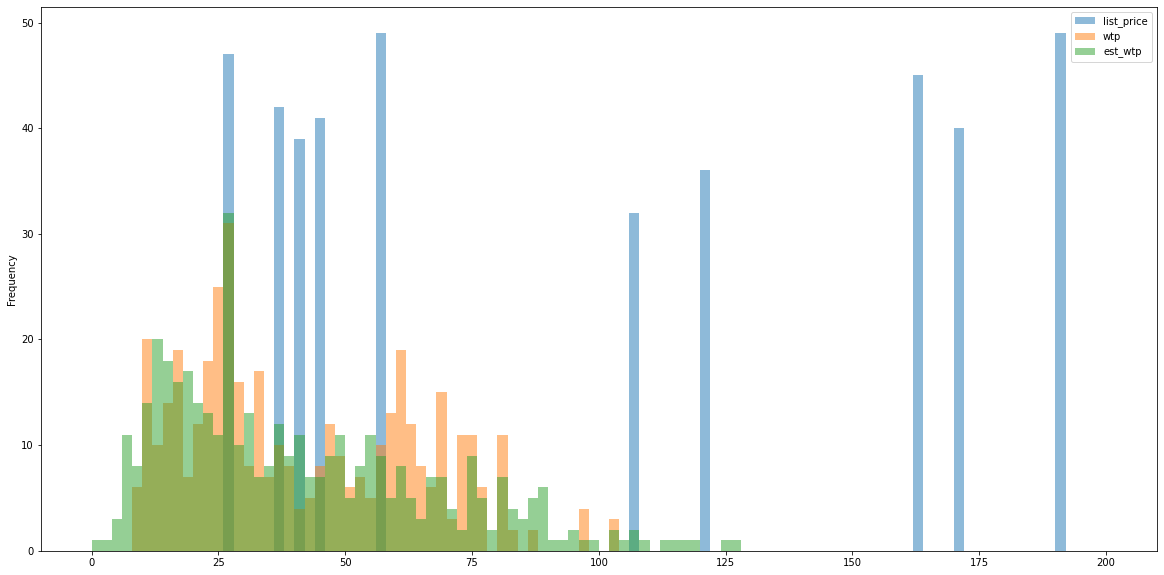

In [258]:
# Distribution of price-like variables
df[['list_price', 'wtp', 'est_wtp']].plot.hist(bins=100, alpha=0.5, figsize=(20,10), range=(0,200))

<AxesSubplot:xlabel='index', ylabel='price'>

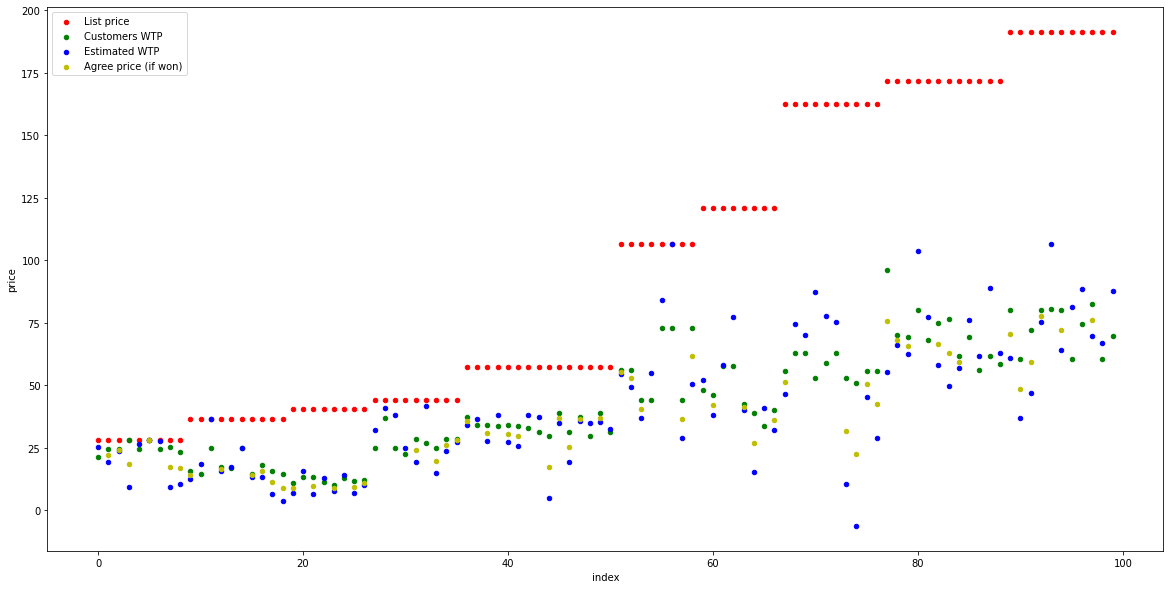

In [259]:
# Prices for random sample of quotes
examples = df.sample(100).sort_values(by='list_price').reset_index(drop=True).reset_index()
ax = examples.plot.scatter(x='index', y='list_price', color='r', label='List price', figsize=(20,10))
examples.plot.scatter(x='index', y='wtp', color='g', label='Customers WTP', ax=ax)
examples.plot.scatter(x='index', y='est_wtp', color='b', label='Estimated WTP', ax=ax)
examples.plot.scatter(x='index', y='price', color='y', label='Agree price (if won)', ax=ax)

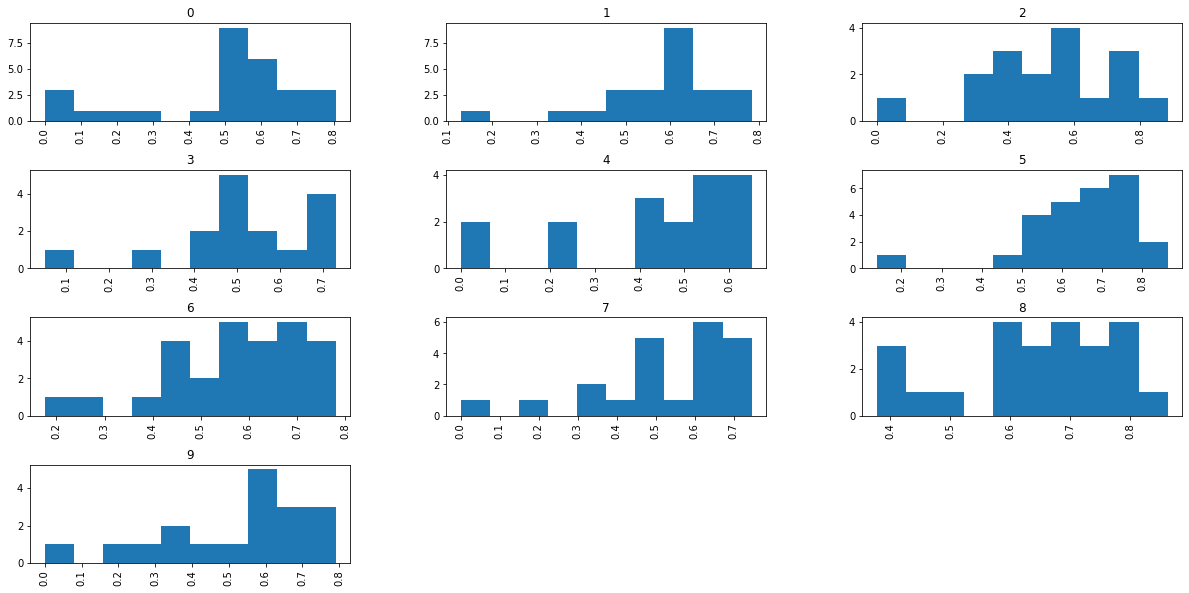

In [260]:
# Distribution of discounts on won deals by salesperson
df['discount'] = np.where(df['result']==1, 1 - df['price']/df['list_price'], np.nan)
_ = df['discount'].hist(by=df['salesperson'], figsize=(20,10))

### Analysis by salesperson

In [251]:
ss = df.reset_index().groupby('salesperson').agg({'index':'count', 'discount':'mean', 'result':'mean'
    , 'wtp':'sum', 'price':'sum', 'sales_wtp_bias':'mean', 'sales_wtp_uncertainty':'mean'})
ss['pct_wtp_captured'] = ss['price']/ss['wtp']
ss.to_csv('ss.csv')

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:78

Best number of neighbours: {'n_neighbors': 5}


Text(0, 0.5, 'wtp_uncertainty')

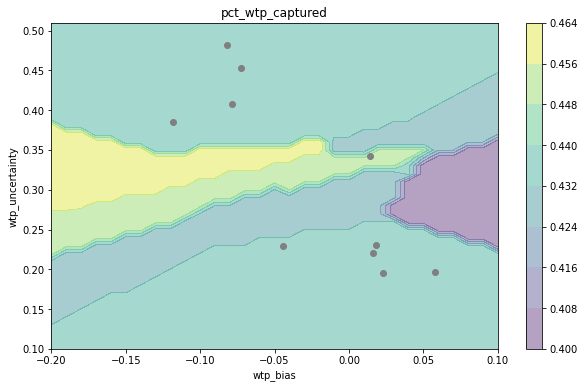

In [254]:
# Get data into numpy arrays
X=ss[['sales_wtp_bias','sales_wtp_uncertainty']].values
y=ss['pct_wtp_captured'].values.reshape(-1, 1)

# Train knn model
num_neigh = np.arange(5, 150, 10)
hyperparameters = dict(n_neighbors=num_neigh)
knr = KNeighborsRegressor()
tune_neigh = GridSearchCV(knr, hyperparameters, cv=10)
neigh = tune_neigh.fit(X,y)
print('Best number of neighbours: ' + str(tune_neigh.best_params_))

# Predict field over range of x1, x2
x1_values = np.arange(-0.2, 0.1, 0.01)
x2_values = np.arange(0.1, 0.52, 0.01)
xx1, xx2 = np.meshgrid(x1_values, x2_values)
X_pred = np.array([xx1.ravel(), xx2.ravel()]).T
z = neigh.predict(X_pred)

# Plot field and also show where individual points are
fig, ax = plt.subplots(figsize=(10,6))
cf = ax.contourf(xx1, xx2, z.reshape(xx1.shape), alpha = 0.4)#, norm=norm)
fig.colorbar(cf, ax=ax)
ax.scatter(x=X[:,0], y=X[:,1], c='grey')
ax.set_title('pct_wtp_captured')
ax.set_xlabel('wtp_bias')
ax.set_ylabel('wtp_uncertainty')

## Model

In [ ]:
X = df[['customer', 'item',	'list_price', 'salesperson', 'item_quality']]
y = df[['result', 'price']]

In [ ]:
def model(X, y=None):

    x_salesperson = torch.tensor(X['salesperson'].values)
    x_item_quality = torch.tensor(X['item_quality'].values)
    x_list_price = torch.tensor(X['list_price'].values)
    x_customer = torch.tensor(X['customer'].values)

    if y is not None:
        y_result = torch.tensor(y['result'].values, dtype=torch.double)
        y_price = torch.tensor(y['price'].values)
    
    # Salespeople
    num_sales = X['salesperson'].nunique() # number of salespeople in data
    # prior on bias in salespersons estimate of customers wtp, a proportion of the wtp
    sales_wtp_bias_mean = pyro.sample(
        "sales_wtp_bias_pct_mean",
        dist.Normal(-0.1,0.2)
    )
    sales_wtp_bias_sigma = pyro.sample(
        "sales_wtp_bias_pct_sigma",
        dist.HalfNormal(0.2)
    )
    # a prior on the error on the salespersons estimate of the customers wtp, a proportion of the wtp
    sales_wtp_uncertainty_scale = pyro.sample(
        "sales_wtp_uncertainty_pct_scale",
        dist.HalfNormal(torch.tensor(0.2))
    )
    # sample salespeople
    with pyro.plate('salespeople', num_sales): 
        with pyro.poutine.reparam(config={"sales_wtp_bias_pct": TransformReparam()}):
            sales_wtp_bias = pyro.sample(
                "sales_wtp_bias_pct",
                dist.TransformedDistribution(
                    dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_sales,]),
                    dist.transforms.AffineTransform(sales_wtp_bias_mean, sales_wtp_bias_sigma),
                ),
            )
        sales_wtp_uncertainty = pyro.sample("sales_wtp_uncertainty_pct", dist.HalfNormal(scale=sales_wtp_uncertainty_scale))
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": TransformReparam()}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.TransformedDistribution(
        #             dist.HalfNormal(scale=torch.ones((num_sales,))),
        #             dist.transforms.AffineTransform(0.0, sales_wtp_uncertainty_scale),
        #         ),
        #     )
        # with pyro.poutine.reparam(config={"sales_wtp_uncertainty_pct": LocScaleReparam()}):#centered=0)}):
        #     sales_wtp_uncertainty = pyro.sample(
        #         "sales_wtp_uncertainty_pct",
        #         dist.LogNormal(loc=0.0, scale=sales_wtp_uncertainty_scale).expand([num_sales,])
        #     )
    #print(sales_wtp_uncertainty_scale)
    #print(sales_wtp_uncertainty)


    #print('salespeople shapes: ', sales_wtp_bias.shape, sales_wtp_uncertainty.shape)

    # Customers
    num_cust= X['customer'].nunique()
    #num_cust = len(X) # number of customers (and rows) in data
    #print(num_cust)
    #prior_beta_quality_loc = pyro.distributions.Uniform(5,10) # prior of the mean of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    #prior_beta_quality_scale = pyro.distributions.Uniform(1,2) # prior of the std deviation of the coefficient of item quality in customers assessment of their wtp, £ per unit of quality
    beta_quality_loc = pyro.sample("beta_quality_loc", 
            dist.TransformedDistribution(
                dist.Uniform(5,15),
                dist.transforms.ExpTransform().inv
            )
    ) # sample mean betas from prior distribution
    beta_quality_scale = pyro.sample("beta_quality_scale", 
        dist.InverseGamma(1, 1)
    )
    #print(beta_quality_loc, beta_quality_scale)
     # # sample std deviation of beta from prior distribution
    #print(beta_quality_loc, beta_quality_scale)
    #beta_quality = torch.distributions.LogNormal(beta_quality_loc, beta_quality_scale).sample([num_cust,])
    #print(beta_quality.shape)


    with pyro.plate('customers', num_cust): #sample customers, all from same distribution for now
    #     with pyro.poutine.reparam(config={"beta_quality": TransformReparam()}):
    #         beta_quality = pyro.sample(
    #             "beta_quality",
    #             dist.TransformedDistribution(
    #                 dist.Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).expand([num_cust,]),
    #                 dist.transforms.AffineTransform(beta_quality_loc, beta_quality_scale),
    #             ),
    #         )

        # with pyro.poutine.reparam(config={"beta_quality": LocScaleReparam()}):#centered=0)}):
        #     beta_quality = pyro.sample(
        #         "beta_quality",
        #         dist.LogNormal(loc=beta_quality_loc, scale=beta_quality_scale).expand([num_cust,])
        #     )

        beta_quality = pyro.sample("beta_quality", pyro.distributions.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))

    #print('customer params shape: ', beta_quality.shape)
    #print(x_item_quality.shape, beta_quality.shape, x_customer.shape, x_list_price.shape)
    #wtp = pyro.deterministic("wtp", torch.clamp(x_item_quality * beta_quality[x_customer], min=torch.ones_like(x_list_price), max=x_list_price))
    wtp_unbound = x_item_quality * beta_quality[x_customer]
    wtp = torch.nn.functional.softplus(wtp_unbound)
    #print(wtp.shape, sales_wtp_uncertainty.shape, x_salesperson.shape)
    wtp_uncertainty = wtp * sales_wtp_uncertainty[x_salesperson]
    #print('wtp shapes: ', wtp.shape, wtp_uncertainty.shape)
    #print('shape of x_list_price:', x_list_price.shape)
    #print(wtp_uncertainty.min(), wtp.min(), sales_wtp_uncertainty[x_salesperson].min())
    #print(sales_wtp_uncertainty)
    #est_wtp = torch.clamp(
    est_wtp = pyro.sample(
            "estimated_wtp",
            dist.FoldedDistribution(
                pyro.distributions.Normal(wtp, wtp_uncertainty)
            )
        #), 
        #min=torch.ones_like(x_list_price), 
        #max=x_list_price
    )
    #print('shape of est_wtp', est_wtp.shape)
    #prob_win = torch.where(wtp < est_wtp, torch.zeros_like(x_list_price), torch.ones_like(x_list_price))
    prob_win = expit(wtp - est_wtp)

    with pyro.plate('negotiations'):
        
        result = pyro.sample("result", pyro.distributions.Bernoulli(prob_win), obs = None if y is None else y_result)
        #hidden_price = torch.where(wtp < x_list_price, (est_wtp+wtp) /2, x_list_price)
        #if y is not None:
            #mask = y_result == torch.tensor(1)
            #with pyro.poutine.mask(mask = mask):#.type(torch.ByteTensor)):
                #price = pyro.sample("price_if_won", pyro.distributions.Normal(hidden_price, 0.01), obs = y_price)#[mask])#None if y is None else y_price)
                #price = pyro.sample("price_if_won", pyro.distributions.Delta(hidden_price), obs = y_price)#[mask])#None if y is None else y_price)

    #outcome[c] = {'item':i, 'result':result, 'price':hidden_price, 'list_price':list_price[i].item(), 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s}

    return result#, hidden_price, None if y is None else price